In [ ]:
import torch
import torchvision as torchvision
from torchvision import models,datasets,transforms
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
params = { 'batch_size':10,
           'shuffle':True,
           'num_workers':8 }

In [ ]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(256), #Augmented
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive'

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(path,"Train"),transform = transform )

In [ ]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
test_dataset = datasets.ImageFolder(os.path.join(path, 'Test'),transform = transform )

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, **params)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, **params)

In [ ]:
class_names = train_dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('DataSet description\n')
print('Train dataset = {}\n'.format(len(train_dataset)))
print('Test dataset = {}\n'.format(len(test_dataset)))
print('Classes = {}'.format(class_names))

DataSet description

Train dataset = 2000

Test dataset = 2000

Classes = ['Fake', 'Live']


In [ ]:
def train(model, loss_fn, optimizer, num_epochs=25):

    best_acc = 0

    for epoch in range(num_epochs):
        
        print('Epoch {}'.format(epoch+1))
        
        # Train dataset
        model.train()
        train_loss = 0.0
        train_correct = 0
        size = len(train_dataset)
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(preds == labels.data)
            
        train_loss = train_loss / size
        train_acc = train_correct.double() / size
            
        print('Training Loss: {} Acc: {}'.format(train_loss, train_acc))
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        size = len(test_dataset)
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # zero the gradients
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(preds == labels.data) 

        val_loss = val_loss / size
        val_acc = val_correct.double() / size    

        print('Validation Loss: {} Acc: {}'.format(val_loss, val_acc))    
            
        if val_acc > best_acc:
            best_acc = val_acc

    print('Best val Acc: {}'.format(best_acc))

    return model

In [ ]:
net = torchvision.models.densenet121(pretrained=True)
for param in net.parameters():
    param.requires_grad = False 

ft = net.classifier.in_features 
net.classifier = nn.Linear(ft, 5)

net = net.to(device)

loss = nn.CrossEntropyLoss()


optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9) 

In [ ]:
net = train(net,loss,optimizer,num_epochs=10)

Epoch 1
Training Loss: 0.4517132270336151 Acc: 0.7825
Validation Loss: 0.27457665286958216 Acc: 0.893
Epoch 2
Training Loss: 0.29301542630419136 Acc: 0.8785
Validation Loss: 0.28075719353742895 Acc: 0.879
Epoch 3
Training Loss: 0.30783294977620246 Acc: 0.866
Validation Loss: 0.37547835404984653 Acc: 0.82
Epoch 4
Training Loss: 0.2960009234957397 Acc: 0.8695
Validation Loss: 0.22432544182986022 Acc: 0.906
Epoch 5
Training Loss: 0.27984530446119604 Acc: 0.884
Validation Loss: 0.36892750561237336 Acc: 0.8275
Epoch 6
Training Loss: 0.28759419908281414 Acc: 0.875
Validation Loss: 0.23616260615177453 Acc: 0.892
Epoch 7
Training Loss: 0.2758274491596967 Acc: 0.8875
Validation Loss: 0.2517326857242733 Acc: 0.8885
Epoch 8
Training Loss: 0.2785899247415364 Acc: 0.8725
Validation Loss: 0.23788816089741885 Acc: 0.892
Epoch 9
Training Loss: 0.2732962136156857 Acc: 0.882
Validation Loss: 0.29680343156680467 Acc: 0.8685
Epoch 10
Training Loss: 0.3047274356801063 Acc: 0.868
Validation Loss: 0.21662850

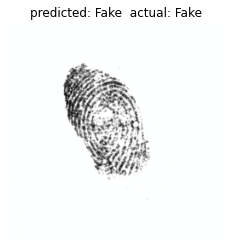

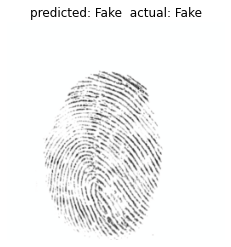

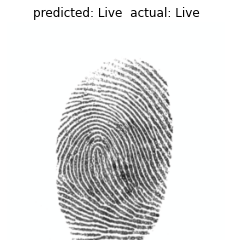

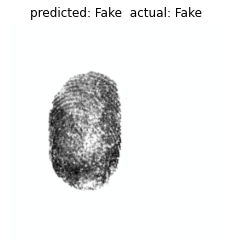

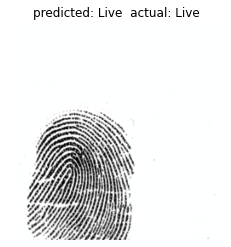

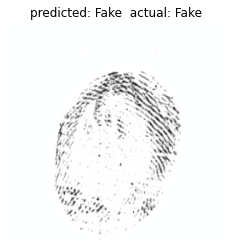

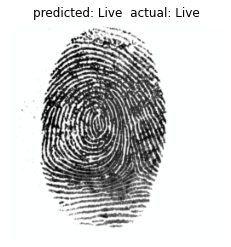

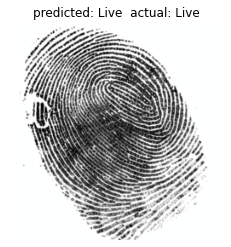

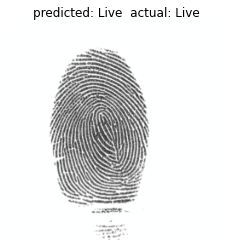

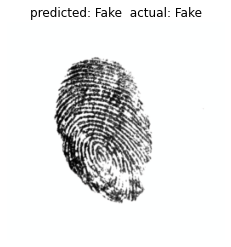

In [ ]:
net.eval()

fig = plt.figure()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for j in range(10):
            ax = plt.subplot(1, 1, 1)
            ax.axis('off')
            ax.set_title('predicted: {}  actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
            imshow(inputs.cpu().data[j])
        break